# Entrenamiento de un modelo de difusión

Basado en https://www.kaggle.com/code/ebrahimelgazar/diffusion-model-u-net

Vamos a construir un modelo de difusión utilizando un dataset de imágenes sencillas. Vamos a añadir ruido a estas imágenes y a entrenar una red neuronal de tipo U-net para que aprenda a quitar el ruido.

Por último, utilizaremos esta red entrenada para probar a generar nuevas imágenes.

Respecto a la solución en la que se basa, este notebook arregla el orden de las etiquetas y entrena un modelo de difusión condicionado con las etiquetas de las clases de las imágenes, de manera que luego se pueda escoger la clase a la hora de generar nuevas imágenes.

#### Dataset: pixel art

https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art

#### Referencias

https://arxiv.org/abs/2006.11239

https://arxiv.org/abs/2010.02502

In [3]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from torchvision.utils import save_image, make_grid
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

### Descargamos y exploramos el dataset

In [5]:
import kagglehub

# Descargamos el dataset usando kaaglehub
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

In [6]:
import numpy as np
# Vamos a cargar unas cuantas imágenes y visualizarlas

imgpath = os.path.join(path, "images/images/")
# sample de 64 imagenes
images = os.listdir(imgpath)
#images = np.random.choice(images, 1000)

In [7]:
import pandas as pd
labelspath = os.path.join(path, "labels.csv")
# filas: Image Index, Image Path, label

labels = pd.read_csv(labelspath)

# aplicar funcion para modificar Image Path
labels["Image Path"] = labels["Image Path"].apply(lambda x: x[x.rfind('/') + 1:len(x)-4]+'.JPEG')

# to dict
labelsdict = labels.set_index("Image Path").to_dict()["Label"]

# labels for images
labels = []
for img in images:
    labels.append(labelsdict[img] if img in labelsdict else None)

In [9]:
# One hot to number
labels_num = []
labels_arr = []
for lab in labels:
    if lab is None:
        labels_num.append(-1)
        continue
    lab = lab[1:-1]
    lab = lab.split(" ")
    lab_arr = [int(float(x)) for x in lab]
    lab_numeric = np.argmax(lab_arr)
    labels_arr.append(lab_arr)
    labels_num.append(lab_numeric)

print(labels_num[0:10])

[-1, 0, 4, 4, 4, 1, 1, 1, 1, 1]


In [10]:
# Ahora, un array ordenado de labels [1, 2, 3...] --> es el orden de los .npy, o eso creo
print(images[0:5])
labels_ordered = []
for i in range(len(images)):
    image = f'image_{i}.JPEG'
    labels_ordered.append(labelsdict[image] if image in labelsdict else None)

print(labels_ordered[0:10])
print(len(labels_ordered))
# contar None en labels
print("None in labels_ordered:", labels_ordered.count(None))

['image_0.JPEG', 'image_1.JPEG', 'image_10.JPEG', 'image_100.JPEG', 'image_1000.JPEG']
[None, '[1. 0. 0. 0. 0.]', '[0. 0. 0. 0. 1.]', '[1. 0. 0. 0. 0.]', '[0. 0. 0. 0. 1.]', '[1. 0. 0. 0. 0.]', '[0. 0. 0. 0. 1.]', '[1. 0. 0. 0. 0.]', '[0. 0. 0. 0. 1.]', '[1. 0. 0. 0. 0.]']
89400
None in labels_ordered: 1


In [11]:
# One hot to number
labels_ordered_num = []
labels_ordered_arr = []
for lab in labels_ordered:
    if lab is None:
        labels_ordered_num.append(-1)
        labels_ordered_arr.append([0,0,0,0,0])
        continue
    lab = lab[1:-1]
    lab = lab.split(" ")
    lab_arr = [int(float(x)) for x in lab]
    lab_numeric = np.argmax(lab_arr)
    labels_ordered_arr.append(lab_arr)
    labels_ordered_num.append(lab_numeric)

labels_ordered_num = np.array(labels_ordered_num)
labels_ordered_arr = np.array(labels_ordered_arr)

Con todo esto, al final tenemos:
- labels_ordered_num: etiquetas con números del 0 al 4
- labels_ordered_arr: etiquetas como one-hot encoded arrays

In [12]:
for i in range(10):
    name = f'image_{i}.JPEG'
    labarr = labels_ordered_arr[i]
    labnum = labels_ordered_num[i]
    labdir = labelsdict[name] if name in labelsdict else None
    print(f'Name: {name} --> From dict: {labdir} || Num: {labnum} || Arr: {labarr}')

    imgidx = images.index(name)
    labsnum = labels_num[imgidx]
    print(f'>> From labels_num: {labsnum}')

Name: image_0.JPEG --> From dict: None || Num: -1 || Arr: [0 0 0 0 0]
>> From labels_num: -1
Name: image_1.JPEG --> From dict: [1. 0. 0. 0. 0.] || Num: 0 || Arr: [1 0 0 0 0]
>> From labels_num: 0
Name: image_2.JPEG --> From dict: [0. 0. 0. 0. 1.] || Num: 4 || Arr: [0 0 0 0 1]
>> From labels_num: 4
Name: image_3.JPEG --> From dict: [1. 0. 0. 0. 0.] || Num: 0 || Arr: [1 0 0 0 0]
>> From labels_num: 0
Name: image_4.JPEG --> From dict: [0. 0. 0. 0. 1.] || Num: 4 || Arr: [0 0 0 0 1]
>> From labels_num: 4
Name: image_5.JPEG --> From dict: [1. 0. 0. 0. 0.] || Num: 0 || Arr: [1 0 0 0 0]
>> From labels_num: 0
Name: image_6.JPEG --> From dict: [0. 0. 0. 0. 1.] || Num: 4 || Arr: [0 0 0 0 1]
>> From labels_num: 4
Name: image_7.JPEG --> From dict: [1. 0. 0. 0. 0.] || Num: 0 || Arr: [1 0 0 0 0]
>> From labels_num: 0
Name: image_8.JPEG --> From dict: [0. 0. 0. 0. 1.] || Num: 4 || Arr: [0 0 0 0 1]
>> From labels_num: 4
Name: image_9.JPEG --> From dict: [1. 0. 0. 0. 0.] || Num: 0 || Arr: [1 0 0 0 0]
>>

### Para entrenar el modelo, vamos a usar imágenes y etiquetas en .npy
### Vamos a explorar antes las categorías

In [17]:
# Vamos a cargar nuestros datos a partir de archivos numpy
imagespath = os.path.join(path, "sprites.npy")
labelspath = os.path.join(path, "sprites_labels.npy")

In [18]:
imgs = np.load(imagespath)
etiquetas = np.load(labelspath)
imgs = imgs[:, :, :, :]
#etiquetas = etiquetas[1:]

# sobrescribir etiquetas por las que están bien ordenadas
etiquetas = np.array(labels_ordered_arr)

print(f"etiquetas: {etiquetas.shape}")
print(f"imgs: {imgs.shape}")

etiquetas: (89400, 5)
imgs: (89400, 16, 16, 3)


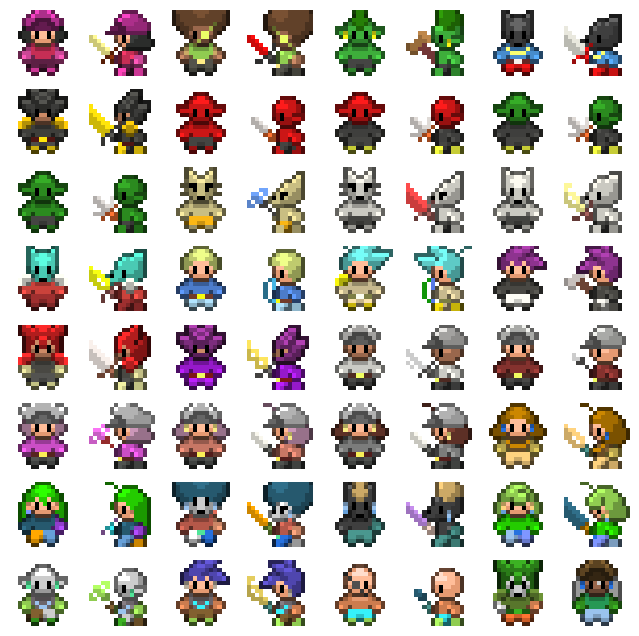

In [20]:
# Visualizamos un grid de 8x8 con sus etiquetas
# random indices
indices = np.random.choice(len(imgs), 64)
indices = np.linspace(0, 64, 64).astype(int)
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        idx = indices[i*8+j]
        ax[i, j].imshow(imgs[idx])
        ax[i, j].axis("off")
        onehot = etiquetas[idx]
        label = np.argmax(onehot)

In [21]:
# lo mismo pero por categoría:
indices_cat = [[], [], [], [], []]
for i in range(len(etiquetas)):
    label = np.argmax(etiquetas[i])
    if len(indices_cat[label]) == 64: continue
    else:
        indices_cat[label].append(i)
    if len(indices_cat[0]) == 64 and len(indices_cat[1]) == 64 and len(indices_cat[2]) == 64 and len(indices_cat[3]) == 64 and len(indices_cat[4]) == 64:
        break

Categoría 0


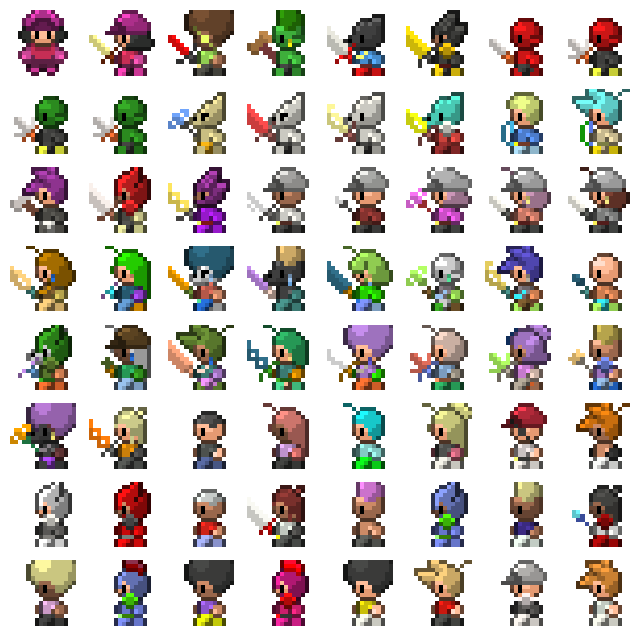

Categoría 1


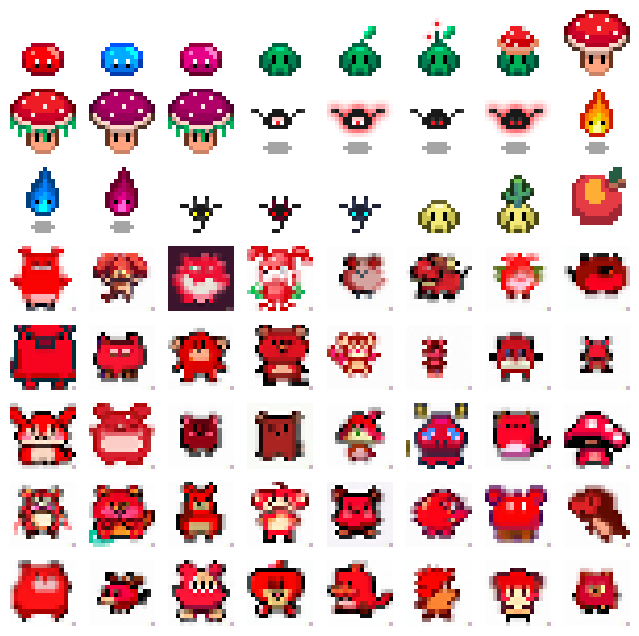

Categoría 2


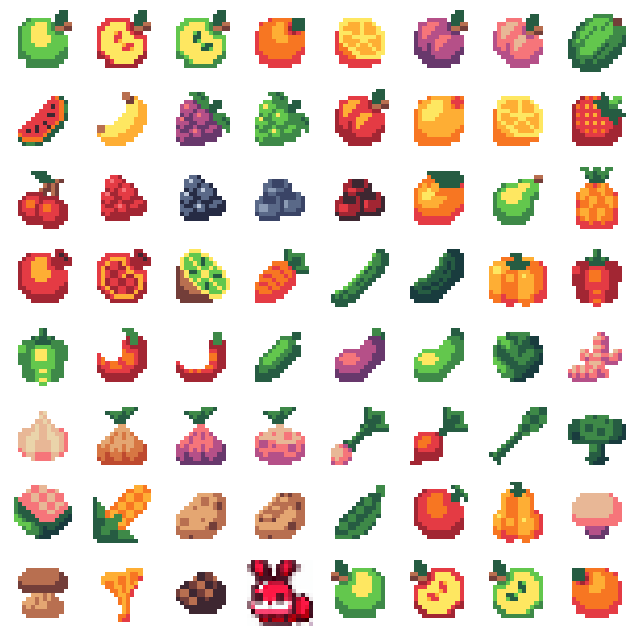

Categoría 3


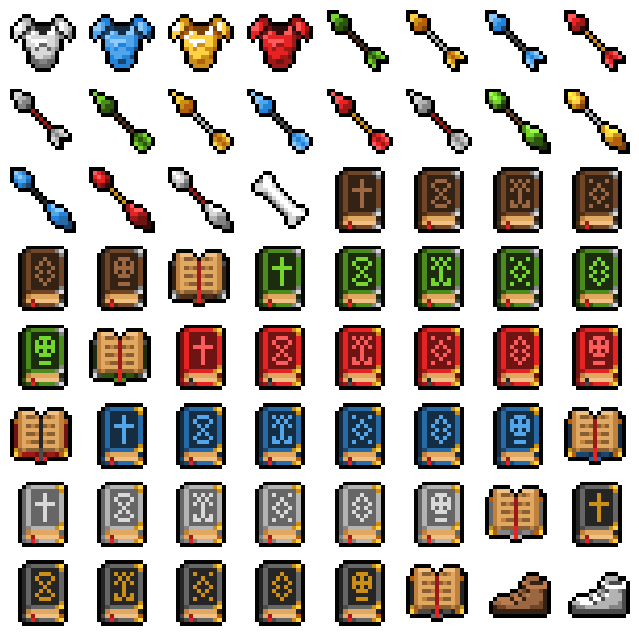

Categoría 4


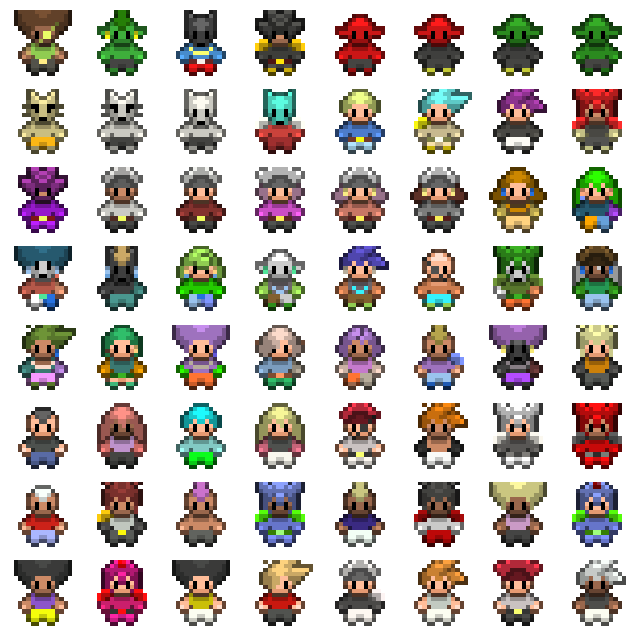

In [24]:
for i, indices in enumerate(indices_cat):
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    print(f'Categoría {i}')
    for i in range(8):
        for j in range(8):
            idx = indices[i*8+j]
            ax[i, j].imshow(imgs[idx])
            ax[i, j].axis("off")
            onehot = etiquetas[idx]
            label = np.argmax(onehot)
    plt.show()

# Definimos el modelo

### Bloque convolucional

Primero, definimos nuestro bloque convolucional base, que luego usaremos para definir las dos ramas de la U-net: el encoder y el decoder.

Para el decoder, necesitamos incluir conxiones residuales.

In [27]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()

        # Comprueba si el número de canales de entrada y salida es el mismo
        self.same_channels = in_channels == out_channels

        # Usamos o no conexiones residuales
        self.is_res = is_res

        # Primer bloque convolucional
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel, stride 1, padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU como función de activación
        )

        # Segundo bloque convolucional
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel, stride 1, padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU como función de activación
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        if not self.is_res: # Si no usamos conexiones residuales, devolvemos la salida de la segunda capa convolucional, como en una red convolucional normal
            return x2
        else: # Si estamos usando conexiones residuales... sumamos la entrada con la salida
            if self.same_channels:
                # Si los tamaños de input y output son iguales, sumamos directamente
                out = x + x2
            else:
                # Si no, aplicamos una capa convolucional 1x1 para ajustar las dimensiones
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2

            # Normalizamos la salida por sqrt(2) para mantener la varianza
            return out / 1.414


    # Método para obtener el número de canales de salida de este bloque
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Método para establecer el número de canales de salida de este bloque
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

### Bloques de la U-net: up (decodificador) y down (codificador)

In [28]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        
        # Cada bloque consta de dos capas ResidualConvBlock, seguidas de una capa MaxPool2d para downsampling
        self.model = nn.Sequential(
            ConvBlock(in_channels, out_channels), 
            ConvBlock(out_channels, out_channels), 
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        
        # ConvTranspose2d para hacer upsample y dos ResidualConvBlock
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2), # kernel_size=2, stride=2 --> upsampling
            ConvBlock(out_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        # Añadimos como nuevos canales los canales de la skip connection
        x = torch.cat((x, skip), 1)
        return self.model(x)

### Embedding

In [29]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        ''' Modelo genérico de embedding con una única capa feed-forward para embeber datos de entrada con dimensión input_dim a un espacio de embedding de dimensión emb_dim. '''
        self.input_dim = input_dim
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Aplanamos la entrada
        return self.model(x)

### Definimos el modelo completo: contextUnet

In [30]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28): 
        # in_channels - Número de canales de la imagen de entrada
        # n_feat - Tamaño de la capa oculta
        # cfeat - context features, número de características de contexto
        # height - Altura de la imagen de entrada (asumimos que es cuadrada)
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  # asumimos h == w... imagen cuadrada

        ### DOWN
        ################################################################################################
        # Inicializamos la capa convolucional inicial
        self.init_conv = ConvBlock(in_channels, n_feat, is_res=True)

        # Inicializamos la capa de down-sampling del U-Net con dos niveles
        self.down1 = UnetDown(n_feat, n_feat)        # down1 # [10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2*n_feat)    # down2 # [10, 256, 4,  4]
        
        # Añadimos un tercer nivel que no sea una capa convolucional completa sino solo un pooling
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        ### EMBEDDING
        ################################################################################################
        # Hacemos un embedding de las características de contexto y del tiempo (el paso temporal, timestep)
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        ### UP
        ################################################################################################
        # Ahora los 3 nieveles de up-sampling
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample 
            nn.GroupNorm(8, 2 * n_feat), # normalize                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Capa de salida --> Volvemos a la cantidad de canales de la imagen de entrada
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # Reducimos el número de feature maps   #in_channels = 2*n_feat, out_channels=n_feat, kernel_size=1, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalizamos
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # Aquí output_channels = in_channels
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # El forward de la red depende del timpstep (t) y, opcionalmente, del contexto (c)

        # Pasamos la imagen de entrada por la capa convolucional inicial
        x = self.init_conv(x)
        # Pasamos por las capas de down-sampling
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]
        
        # Convertimos la salida de down2 a un vector
        hiddenvec = self.to_vec(down2)
        
        # Si no se proporciona contexto, lo inicializamos a cero
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
            
        # Hacemos el embedding de las características de contexto y del tiempo
        cemb1 = self.contextembed1(c)     # (batch, 2*n_feat, 1,1)
        cemb1 = cemb1.view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)    # (batch, 2*n_feat, 1,1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)    # (batch, n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)   # (batch, n_feat, 1,1)

        # Pasamos por las capas de up-sampling
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2) 
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# Entrenamiento del modelo

### Hiperparámetros

In [31]:
# Hiperparámetros de difusión
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# Hipérparámetros de la red
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64: tamaño de la capa oculta
n_cfeat = 5 # Tamaño del vector de contexto
height = 16 # Tamaño de las imágenes (16x16)

# Paths para guardar el modelo
model_outname = 'model.pth'
outpath = './output/'
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Hiperparámetros de entrenamiento
batch_size = 64
n_epoch = 50
lrate=1e-3

print('Device: ', device)

Device:  cuda:0


### DDPM schedule

Construimos un scheduler para añadir ruido según el algoritmo estándar, el DDPM

Text(0.5, 1.0, 'ab(t)')

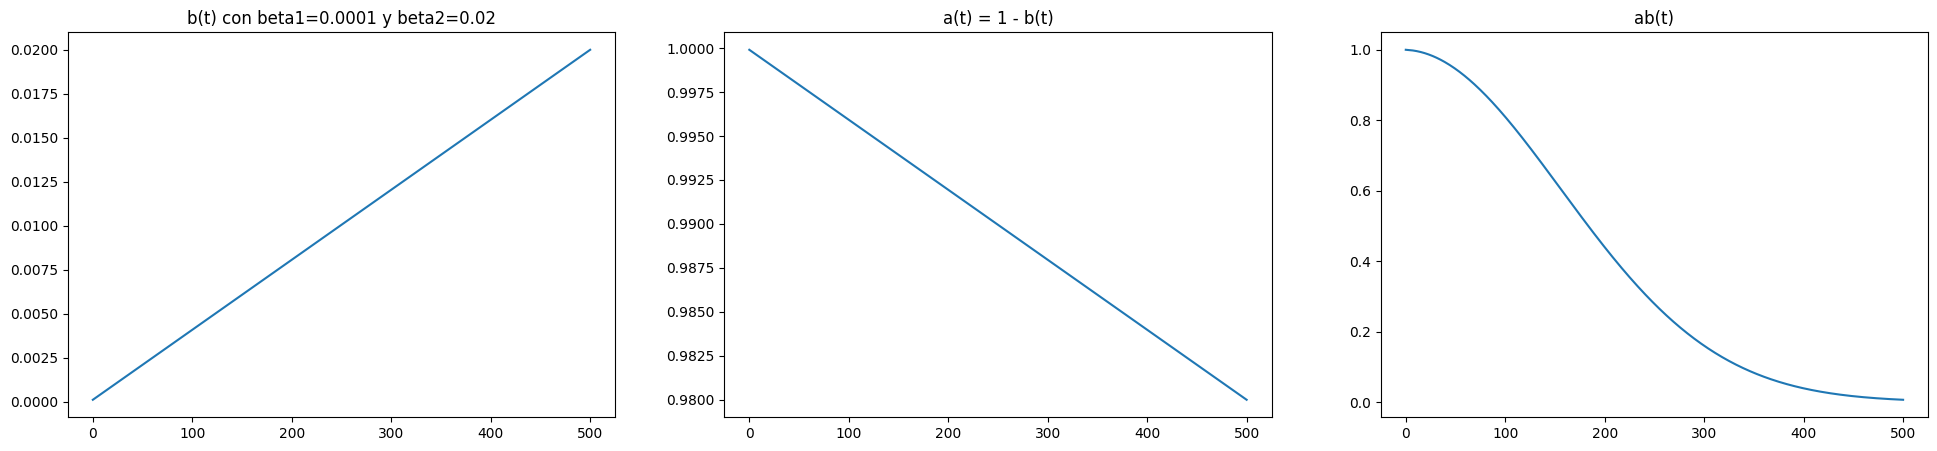

In [32]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

# plot
fig, axs = plt.subplots(1, 3, figsize=(8*3, 5))
axs[0].plot(b_t.cpu().numpy())
axs[0].set_title(f'b(t) con beta1={beta1} y beta2={beta2}')

axs[1].plot(a_t.cpu().numpy())
axs[1].set_title('a(t) = 1 - b(t)')

axs[2].plot(ab_t.cpu().numpy())
axs[2].set_title('ab(t)')

### Creamos el modelo

In [33]:
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

print(nn_model)

# Number of parameters in the model
n_params = sum(p.numel() for p in nn_model.parameters())
print(f"Number of parameters: {n_params}")

ContextUnet(
  (init_conv): ConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

### Cargamos las imágenes y itiquetas a partir de archivos .npy donde están almacenadas, usando nuestro custom dataset

In [34]:
class CustomDataset(Dataset):
    ''' Clase para luego hacer un dataloader con el formato adecuado '''
    def __init__(self, sfilename, lfilename, transform, null_context=False):
        if isinstance(sfilename, str):
            self.sprites = np.load(sfilename)
        else:
            self.sprites = sfilename
        if isinstance(lfilename, str):
            self.slabels = np.load(lfilename)
        else:
            self.slabels = lfilename
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape
                
    # Número de elementos en el dataset
    def __len__(self):
        return len(self.sprites)
    
    # Obtener un elemento y etiqueta
    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.float32)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.float32)
        return (image, label)

    def getshapes(self):
        # Devuelve las dimensiones de los datos de imágenes y las etiquetas
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [35]:
dataset = CustomDataset(imagespath, labelspath, transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


### Entrenar el modelo

In [36]:
# Definimos optimizador Adam
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

# Función para añadir ruido a las imágenes para un nivel específico t, usando el scheduler
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [37]:
# Ponemos el modelo en modo de entrenamiento
nn_model.train()

loss_hist = []

# Bucle de entrenamiento
for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # Cambiamos el learning rate en cada epoch a mano
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    # Creamos una barra de progreso
    pbar = tqdm(dataloader, mininterval=2)

    # Bucle usando el dataloader... cada x es un batch de imágenes
    for x, labels in pbar: #
        optim.zero_grad() # reseteamos gradientes

        x = x.to(device) # batch de imágenes al device
        # labels vector to dtype float
        labels = labels.to(torch.float32).to(device)
        
        # ruido para añadir a las imágenes
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)

        # Usamos el modelo para predecir el ruido
        #pred_noise = nn_model(x_pert, t / timesteps, labels)
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # La función de pérdida mide la diferencia entre el ruido predicho y el ruido real
        loss = F.mse_loss(pred_noise, noise)
        loss_hist.append(loss.item())

        # Retropropagamos
        loss.backward()
        optim.step()

epoch 0


100%|██████████| 1397/1397 [00:31<00:00, 44.16it/s]


epoch 1


100%|██████████| 1397/1397 [00:27<00:00, 50.09it/s]


epoch 2


100%|██████████| 1397/1397 [00:27<00:00, 50.38it/s]


epoch 3


100%|██████████| 1397/1397 [00:28<00:00, 49.03it/s]


epoch 4


100%|██████████| 1397/1397 [00:27<00:00, 50.83it/s]


epoch 5


100%|██████████| 1397/1397 [00:27<00:00, 50.78it/s]


epoch 6


100%|██████████| 1397/1397 [00:27<00:00, 50.66it/s]


epoch 7


100%|██████████| 1397/1397 [00:27<00:00, 50.13it/s]


epoch 8


100%|██████████| 1397/1397 [00:27<00:00, 49.92it/s]


epoch 9


100%|██████████| 1397/1397 [00:28<00:00, 49.29it/s]


epoch 10


100%|██████████| 1397/1397 [00:28<00:00, 49.21it/s]


epoch 11


100%|██████████| 1397/1397 [00:27<00:00, 50.27it/s]


epoch 12


100%|██████████| 1397/1397 [00:27<00:00, 50.32it/s]


epoch 13


100%|██████████| 1397/1397 [00:28<00:00, 48.98it/s]


epoch 14


100%|██████████| 1397/1397 [00:28<00:00, 49.67it/s]


epoch 15


100%|██████████| 1397/1397 [00:28<00:00, 49.06it/s]


epoch 16


100%|██████████| 1397/1397 [00:28<00:00, 49.06it/s]


epoch 17


100%|██████████| 1397/1397 [00:28<00:00, 49.07it/s]


epoch 18


100%|██████████| 1397/1397 [00:28<00:00, 49.35it/s]


epoch 19


100%|██████████| 1397/1397 [00:28<00:00, 49.69it/s]


epoch 20


100%|██████████| 1397/1397 [00:28<00:00, 48.90it/s]


epoch 21


100%|██████████| 1397/1397 [00:27<00:00, 50.04it/s]


epoch 22


100%|██████████| 1397/1397 [00:29<00:00, 48.09it/s]


epoch 23


100%|██████████| 1397/1397 [00:27<00:00, 50.82it/s]


epoch 24


100%|██████████| 1397/1397 [00:27<00:00, 50.25it/s]


epoch 25


100%|██████████| 1397/1397 [00:27<00:00, 50.72it/s]


epoch 26


100%|██████████| 1397/1397 [00:27<00:00, 50.64it/s]


epoch 27


100%|██████████| 1397/1397 [00:27<00:00, 50.72it/s]


epoch 28


100%|██████████| 1397/1397 [00:27<00:00, 50.83it/s]


epoch 29


100%|██████████| 1397/1397 [00:27<00:00, 50.71it/s]


epoch 30


100%|██████████| 1397/1397 [00:27<00:00, 50.80it/s]


epoch 31


100%|██████████| 1397/1397 [00:28<00:00, 49.16it/s]


epoch 32


100%|██████████| 1397/1397 [00:30<00:00, 46.44it/s]


epoch 33


100%|██████████| 1397/1397 [00:30<00:00, 46.52it/s]


epoch 34


100%|██████████| 1397/1397 [00:29<00:00, 47.45it/s]


epoch 35


100%|██████████| 1397/1397 [00:29<00:00, 47.19it/s]


epoch 36


100%|██████████| 1397/1397 [00:29<00:00, 47.77it/s]


epoch 37


100%|██████████| 1397/1397 [00:29<00:00, 47.43it/s]


epoch 38


100%|██████████| 1397/1397 [00:28<00:00, 49.05it/s]


epoch 39


100%|██████████| 1397/1397 [00:28<00:00, 49.04it/s]


epoch 40


100%|██████████| 1397/1397 [00:28<00:00, 48.99it/s]


epoch 41


100%|██████████| 1397/1397 [00:28<00:00, 48.91it/s]


epoch 42


100%|██████████| 1397/1397 [00:28<00:00, 49.08it/s]


epoch 43


100%|██████████| 1397/1397 [00:28<00:00, 48.87it/s]


epoch 44


100%|██████████| 1397/1397 [00:27<00:00, 50.19it/s]


epoch 45


100%|██████████| 1397/1397 [00:27<00:00, 50.97it/s]


epoch 46


100%|██████████| 1397/1397 [00:27<00:00, 50.80it/s]


epoch 47


100%|██████████| 1397/1397 [00:27<00:00, 50.72it/s]


epoch 48


100%|██████████| 1397/1397 [00:27<00:00, 50.83it/s]


epoch 49


100%|██████████| 1397/1397 [00:27<00:00, 50.49it/s]


Text(0, 0.5, 'Loss')

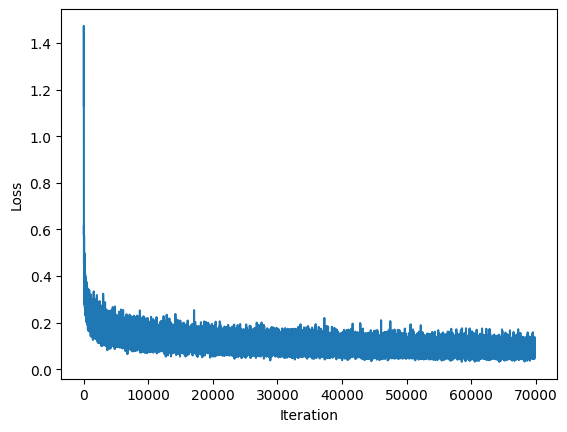

In [38]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# final loss ~0.1 cuando usamos labels

### Guardamos el modelo entrneado

In [39]:
torch.save(nn_model.state_dict(), os.path.join(outpath, model_outname))
print(f'saved model at {os.path.join(outpath, model_outname)}')

saved model at ./output/model.pth


### Hacemos sampling

In [40]:
def denoise_add_noise(x, t, pred_noise, z=None):
    '''
    Función para quitar el ruido predicho por el modelo (y añadir algo de ruido aleatorio)
    '''
    if z is None:
        z = torch.randn_like(x)

    # Añadimos ruido gaussiano usando el scheduler de ruido b_t, definido previamente
    noise = b_t.sqrt()[t] * z # Si z=0, entonces no añadimos ruido

    # Quitamos el ruido predicho por el modelo
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20, c=None):
    '''
    n_sample: numero de samples a generar
    save_rate: cada cuantos timesteps se guarda una imagen --> Tengamos en cuenta que en nuestro modelo tenemos 1000 timesteps para cada imagen
    ddpm es el método estándar para muestrear imágenes
    '''
    # x_T ~ N(0, 1), hacemos un sampleo de ruido...
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # definimos una lista para guardar las imágenes intermedias
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'Paso {i:3d}/{timesteps}...', end='\r')

        # Necesitamos que el step sea un tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # Añadimos algo de ruido tras cada paso, excepto en el último paso
        z = torch.randn_like(samples) if i > 1 else 0

        # Usamos el modelo para predecir el ruido e_(x_t,t)
        eps = nn_model(samples, t, c) 

        # Quitamos el ruido y añadimos algo de ruido de nuevo para evitar el colapso
        samples = denoise_add_noise(samples, i, eps, z)

        # Almacenamos la imagen cuando toca
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [41]:
# Cargamos los pesos del modelo
nn_model.load_state_dict(torch.load(f"{os.path.join(outpath, model_outname)}", map_location=device))
nn_model.eval()
print("Modelo cargado")

Modelo cargado


### Visualizamos ejemplos

In [42]:
# Definimos funciones para normalizar y plotear imágenes

def norm_torch(x_all):
    ''' Normaliza a la unidad las imágenes de un batch de tamaño (n_samples, 3, h, w), siendo x un torch tensor '''
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3)) 
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def plot_grid(x,n_sample,n_rows,save_dir=None,w=0):
    ''' x es ruido aleatorio con dimensiones (n_sample, 3, h, w) '''
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  
    if save_dir is not None:
        save_image(grid, save_dir + f"run_image_w{w}.png")
        print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

(-0.5, 145.5, 73.5, -0.5)

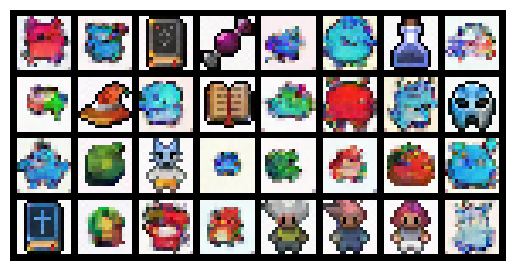

In [43]:
samples, inter = sample_ddpm(32, c=None)
grid = plot_grid(samples,32,4)
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis('off')

### Vamos a hacer un gif para ver todo el proceso

In [44]:
def unorm(x):
    '''
    Normaliza resultados en el rango [0,1]
    Asumimos que x tiene dimensiones (h,w,3)
    '''
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    '''
    Corre la función de arriba para todos los timesteps y samples
    ''' 
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def plot_sample(x_gen_store,n_sample,nrows):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow
    
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0]) 
    plt.close()
    return ani

In [45]:
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

# Añadimos contexto

In [46]:
# Hiperparámetros de difusión
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# Hipérparámetros de la red
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64: tamaño de la capa oculta
n_cfeat = 5 # Tamaño del vector de contexto
height = 16 # Tamaño de las imágenes (16x16)

# Paths para guardar el modelo
model_outname = 'model_with_context.pth'
outpath = './output/'
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Hiperparámetros de entrenamiento
batch_size = 64
n_epoch = 50
lrate=1e-3

# Scheduler
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

## Modelo
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

## Dataset
dataset = CustomDataset(imgs, etiquetas, transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [47]:
# Definimos optimizador Adam
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

# Ponemos el modelo en modo de entrenamiento
nn_model.train()

loss_hist = []

# Bucle de entrenamiento
for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # Cambiamos el learning rate en cada epoch a mano
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    # Creamos una barra de progreso
    pbar = tqdm(dataloader, mininterval=2)

    # Bucle usando el dataloader... cada x es un batch de imágenes
    for x, labels in pbar: #
        optim.zero_grad() # reseteamos gradientes

        x = x.to(device) # batch de imágenes al device
        labels = labels.to(device)
        
        # ruido para añadir a las imágenes
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)

        # Usamos el modelo para predecir el ruido
        pred_noise = nn_model(x_pert, t / timesteps, labels)
        
        # La función de pérdida mide la diferencia entre el ruido predicho y el ruido real
        loss = F.mse_loss(pred_noise, noise)
        loss_hist.append(loss.item())

        # Retropropagamos
        loss.backward()
        optim.step()

epoch 0


100%|██████████| 1397/1397 [00:28<00:00, 48.88it/s]


epoch 1


100%|██████████| 1397/1397 [00:28<00:00, 49.47it/s]


epoch 2


100%|██████████| 1397/1397 [00:27<00:00, 49.92it/s]


epoch 3


100%|██████████| 1397/1397 [00:27<00:00, 49.91it/s]


epoch 4


100%|██████████| 1397/1397 [00:27<00:00, 50.13it/s]


epoch 5


100%|██████████| 1397/1397 [00:27<00:00, 50.22it/s]


epoch 6


100%|██████████| 1397/1397 [00:27<00:00, 50.04it/s]


epoch 7


100%|██████████| 1397/1397 [00:27<00:00, 49.95it/s]


epoch 8


100%|██████████| 1397/1397 [00:27<00:00, 50.31it/s]


epoch 9


100%|██████████| 1397/1397 [00:27<00:00, 50.36it/s]


epoch 10


100%|██████████| 1397/1397 [00:27<00:00, 49.99it/s]


epoch 11


100%|██████████| 1397/1397 [00:28<00:00, 49.63it/s]


epoch 12


100%|██████████| 1397/1397 [00:27<00:00, 50.58it/s]


epoch 13


100%|██████████| 1397/1397 [00:28<00:00, 49.84it/s]


epoch 14


100%|██████████| 1397/1397 [00:27<00:00, 50.16it/s]


epoch 15


100%|██████████| 1397/1397 [00:27<00:00, 51.46it/s]


epoch 16


100%|██████████| 1397/1397 [00:27<00:00, 51.56it/s]


epoch 17


100%|██████████| 1397/1397 [00:26<00:00, 51.80it/s]


epoch 18


100%|██████████| 1397/1397 [00:27<00:00, 51.67it/s]


epoch 19


100%|██████████| 1397/1397 [00:29<00:00, 48.17it/s]


epoch 20


100%|██████████| 1397/1397 [00:27<00:00, 50.59it/s]


epoch 21


100%|██████████| 1397/1397 [00:27<00:00, 51.31it/s]


epoch 22


100%|██████████| 1397/1397 [00:27<00:00, 51.45it/s]


epoch 23


100%|██████████| 1397/1397 [00:27<00:00, 51.07it/s]


epoch 24


100%|██████████| 1397/1397 [00:28<00:00, 49.01it/s]


epoch 25


100%|██████████| 1397/1397 [00:27<00:00, 49.91it/s]


epoch 26


100%|██████████| 1397/1397 [00:28<00:00, 49.72it/s]


epoch 27


100%|██████████| 1397/1397 [00:27<00:00, 50.13it/s]


epoch 28


100%|██████████| 1397/1397 [00:28<00:00, 49.68it/s]


epoch 29


100%|██████████| 1397/1397 [00:28<00:00, 49.69it/s]


epoch 30


100%|██████████| 1397/1397 [00:27<00:00, 50.50it/s]


epoch 31


100%|██████████| 1397/1397 [00:27<00:00, 50.39it/s]


epoch 32


100%|██████████| 1397/1397 [00:28<00:00, 49.53it/s]


epoch 33


100%|██████████| 1397/1397 [00:28<00:00, 49.11it/s]


epoch 34


100%|██████████| 1397/1397 [00:27<00:00, 49.98it/s]


epoch 35


100%|██████████| 1397/1397 [00:27<00:00, 50.12it/s]


epoch 36


100%|██████████| 1397/1397 [00:27<00:00, 49.97it/s]


epoch 37


100%|██████████| 1397/1397 [00:28<00:00, 49.66it/s]


epoch 38


100%|██████████| 1397/1397 [00:27<00:00, 50.17it/s]


epoch 39


100%|██████████| 1397/1397 [00:27<00:00, 50.33it/s]


epoch 40


100%|██████████| 1397/1397 [00:27<00:00, 50.29it/s]


epoch 41


100%|██████████| 1397/1397 [00:27<00:00, 50.18it/s]


epoch 42


100%|██████████| 1397/1397 [00:27<00:00, 50.22it/s]


epoch 43


100%|██████████| 1397/1397 [00:28<00:00, 49.83it/s]


epoch 44


100%|██████████| 1397/1397 [00:28<00:00, 49.76it/s]


epoch 45


100%|██████████| 1397/1397 [00:29<00:00, 47.98it/s]


epoch 46


100%|██████████| 1397/1397 [00:28<00:00, 49.42it/s]


epoch 47


100%|██████████| 1397/1397 [00:28<00:00, 48.81it/s]


epoch 48


100%|██████████| 1397/1397 [00:28<00:00, 49.24it/s]


epoch 49


100%|██████████| 1397/1397 [00:28<00:00, 48.69it/s]


Text(0, 0.5, 'Loss')

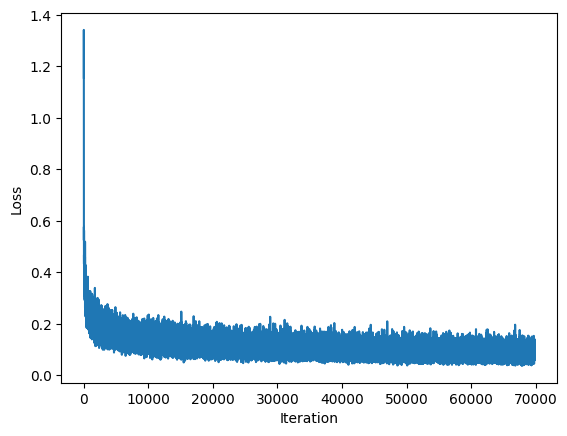

In [48]:
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# final loss ~0.1 cuando usamos labels

In [49]:
torch.save(nn_model.state_dict(), os.path.join(outpath, model_outname))
print(f'saved model at {os.path.join(outpath, model_outname)}')

saved model at ./output/model_with_context.pth


(-0.5, 145.5, 73.5, -0.5)

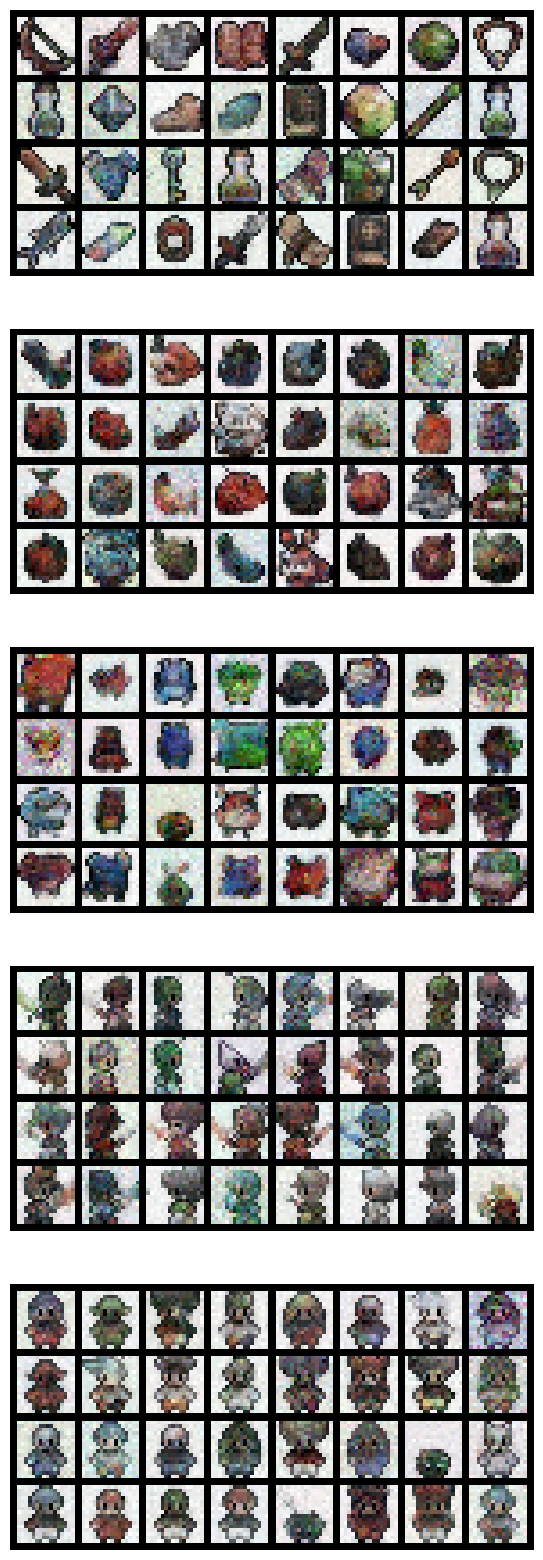

In [50]:
samples, inter = sample_ddpm(32, c=torch.tensor([0.,0.,0.,1.,0.]).to(device))
grid = plot_grid(samples,32,4)
fig, ax = plt.subplots(5, 1, figsize=(8, 4*5))
ax[0].imshow(grid.permute(1,2,0).cpu().numpy())
ax[0].axis('off')

samples, inter = sample_ddpm(32, c=torch.tensor([0.,0.,1.,0.,0.]).to(device))
grid = plot_grid(samples,32,4)
ax[1].imshow(grid.permute(1,2,0).cpu().numpy())
ax[1].axis('off')

samples, inter = sample_ddpm(32, c=torch.tensor([0.,1.,0.,0.,0.]).to(device))
grid = plot_grid(samples,32,4)
ax[2].imshow(grid.permute(1,2,0).cpu().numpy())
ax[2].axis('off')

samples, inter = sample_ddpm(32, c=torch.tensor([1.,0.,0.,0.,0.]).to(device))
grid = plot_grid(samples,32,4)
ax[3].imshow(grid.permute(1,2,0).cpu().numpy())
ax[3].axis('off')

samples, inter = sample_ddpm(32, c=torch.tensor([0.,0.,0.,0.,1.]).to(device))
grid = plot_grid(samples,32,4)
ax[4].imshow(grid.permute(1,2,0).cpu().numpy())
ax[4].axis('off')

(-0.5, 145.5, 73.5, -0.5)

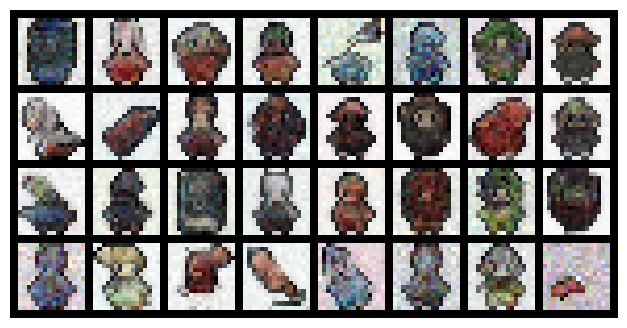

In [51]:
## Probamos a mezclar conceptos
samples, inter = sample_ddpm(32, c=torch.tensor([0.,0.,0.,0.5,0.5]).to(device))
grid = plot_grid(samples,32,4)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(grid.permute(1,2,0).cpu().numpy())
ax.axis('off')